# Titanic Survival

## Import Statements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

## Reading CSV, Exploratory Data Analysis and Splitting data into training and testing data before data transformation to prevent data leakage

In [3]:
df = pd.read_csv("titanic.csv")
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


In [6]:
X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            140
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          553
Embarked         2
dtype: int64

## Making Pipelines to run multiple models(decision tree, random forest, knn, adaboost, gradientboost and xgboost) and transforming data easier

In [7]:
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Sex', 'Embarked', 'Pclass']
drop_features = ['PassengerId','Name','Ticket','Cabin']

In [8]:
numerical_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('num', numerical_preprocessor, numerical_features),
    ('cat', categorical_preprocessor, categorical_features),
    ('drop','drop', drop_features)
])

In [9]:
tree_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DecisionTreeClassifier(criterion='gini',random_state=42))
])

forest_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(criterion='gini',random_state=42))
])

knn_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', KNeighborsClassifier())
])

ada_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', AdaBoostClassifier(random_state=42))
])

gb_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

xgb_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

## Running Cross Validation on the various selected model pipelines

In [10]:
models = {
    "Decision Tree": tree_pipe,
    "Random Forest": forest_pipe,
    "KNN": knn_pipe,
    "AdaBoost": ada_pipe,
    "Gradient Boosting": gb_pipe,
    "XGBoost": xgb_pipe,
}

In [11]:
cv_scores = {}
for name, model in models.items():
    model_cv=cross_val_score(model,X,y,cv=5,scoring='accuracy')
    cv_scores[name] = model_cv.mean()
    print(f"{name}: {model_cv.mean():.4f}")

Decision Tree: 0.7857
Random Forest: 0.8070
KNN: 0.8059
AdaBoost: 0.7980
Gradient Boosting: 0.8283
XGBoost: 0.8137


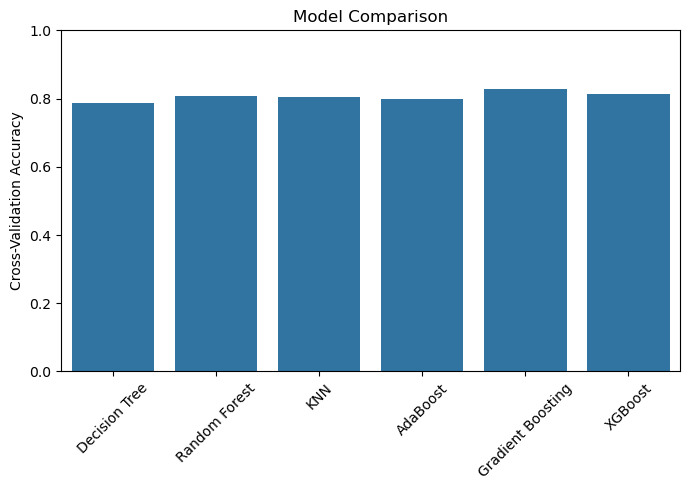

In [12]:
plt.figure(figsize=(7, 5))
sns.barplot(x=list(cv_scores.keys()), y=list(cv_scores.values()))
plt.ylabel("Cross-Validation Accuracy")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

## Performing Hyper-parameter tuning on the best model selected by cross validation

In [13]:
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2,5,10],
    'model__min_samples_leaf': [1,3,5]
}

grid_search = RandomizedSearchCV(gb_pipe, param_grid, cv=5, scoring='accuracy', n_iter=50)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)

{'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_depth': 7, 'model__learning_rate': 0.01}


In [14]:
gb_pipe.set_params(**(grid_search.best_params_))

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Checking Accuracy on Tuned Model

In [ ]:
gb_pipe.fit(X_train,y_train)
y_predict = gb_pipe.predict(X_test) 
accuracy_score(y_test, y_predict)

0.8268156424581006

Accuracy has decreased after fine-tuning the model with randomizedSearchCV  :-[
    <br>
I might have overfitted the model but i couldnt find the time to re-tune it and find out the reason why it decreased.